In [1]:
import numpy as np
import scipy.stats as sps
from tqdm import tqdm
from torchinfo import summary # DEBUG
from functools import partial

from utils.utils import *
from utils.dataset_loaders import *
from models.basic_models import *

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.io import write_video, write_png
from diffusers import UNet3DConditionModel, DDPMScheduler, DDPMPipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

/home/koltakovmi/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
%reload_ext autoreload
%autoreload 2

Creating dataset and dataloader for UCF-101 and MovingMNIST.

In [2]:
# UCF_dataset = UCFDataset("./datasets/UCF-101/")

# UCF_dataloader = DataLoader(UCF_dataset, shuffle=True, batch_size=batch_size)

MovMNIST_dataset = MovMNISTDataset("./datasets/moving_mnist.npy")
MovMNIST_dataloader = DataLoader(MovMNIST_dataset, shuffle=True, batch_size=2)

MovMNIST_frame_dataset = MovMNISTFrameDataset("./datasets/moving_mnist.npy")
MovMNIST_frame_dataloader = DataLoader(MovMNIST_frame_dataset, shuffle=True, batch_size=96)

In [3]:
model_frame, noise_scheduler_frame, optimizer_frame, lr_scheduler_frame, criterion_frame = init_mov_mnist_model_frame(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_frame_dataloader),
    device="cuda:0",
)

In [3]:
model_video, noise_scheduler_video, optimizer_video, lr_scheduler_video, criterion_video = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=4,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device="cuda:1",
)

In [4]:
trainer = TrainableDiffusionModel(
    model_ref = model_frame,
    optimizer_ref = optimizer_frame,
    lr_scheduler_ref=lr_scheduler_frame,
    noise_scheduler = noise_scheduler_frame,
    criterion = criterion_frame,
    device="cuda:1",
    model_type="image",
    cross_att_dim=4,
    EMA_start=2500,
)

test_losses = trainer.fit(
    dataloader = MovMNIST_frame_dataloader,
    save_path = "./models/trained/mov_mnist_frames_batch96/",
    num_epochs = 4,
)

  0%|                                                                                                                                                                                                                                 | 0/2084 [00:00<?, ?it/s]

 13%|█████████████████████████▊                                                                                                                                                                                | 266/2084 [22:50<2:35:09,  5.12s/it, MSE=0.016]

In [4]:
trainer = TrainableDiffusionModel(
    model_ref = model_video,
    optimizer_ref = optimizer_video,
    lr_scheduler_ref=lr_scheduler_video,
    noise_scheduler = noise_scheduler_video,
    criterion = criterion_video,
    device="cuda:1",
    model_type="video",
    cross_att_dim=4,
    EMA_start=7500,
)

test_losses = trainer.fit(
    dataloader = MovMNIST_dataloader,
    save_path = "./models/trained/test/",
    num_epochs = 4,
)

  0%|▏                                                                                                                                                                                                                                       | 4/5000 [00:23<8:02:58,  5.80s/it, MSE=0.878]


KeyboardInterrupt: 

In [8]:
sampler = TrainableDiffusionModel(
    model_ref = model_frame,
    optimizer_ref = optimizer_frame,
    lr_scheduler_ref=lr_scheduler_frame,
    noise_scheduler = noise_scheduler_frame,
    criterion = criterion_frame,
    device="cuda:0",
    model_type="image",
    cross_att_dim=4,
    EMA_start=0,
)

sampler.load_state(base_dir_path="./models/trained/mov_mnist_frames_batch96/", suffix="8000",
                   load_optimizer=False, load_lr_sched=False)
images = sampler.sample(num_samples=8)

 29%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 29/100 [00:03<00:08,  8.85it/s]


KeyboardInterrupt: 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.93it/s]


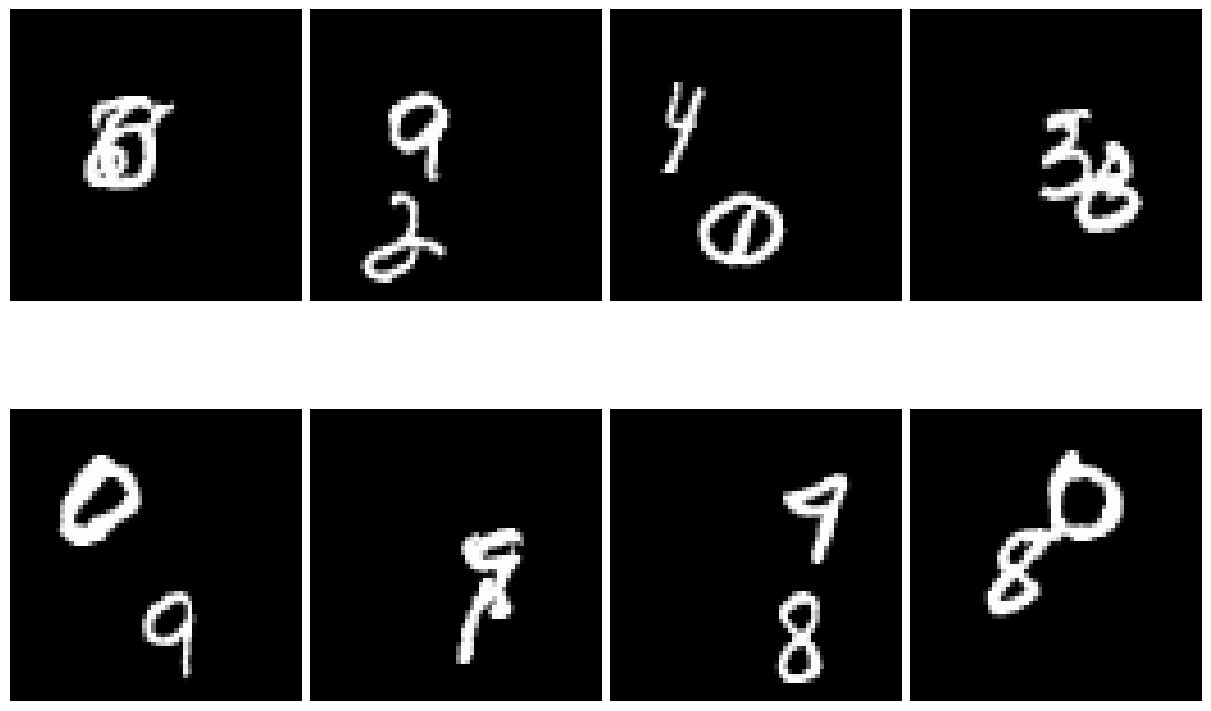

In [10]:
images = sampler.sample(num_samples=8)

fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True)
fig.set_size_inches(12, 8)

for i, im in enumerate(images):
    ax[i // 4][i % 4].imshow(im.permute(1, 2, 0), cmap="grey")
    ax[i // 4][i % 4].axis("off")

plt.show()

In [ ]:
for i, im in enumerate(images):
    write_png(im, f"results/MovMNIST/frames_batch96/8000_{i}.png")

Trying default DDPMScheduler for working with videos.

In [ ]:
model, noise_scheduler, optimizer, lr_scheduler, criterion = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=1,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device="cuda:0"
)

In [ ]:
losses_mixed = train_simple_new(
    model=model,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    noise_cov=mixed_noise,
    cross_att_dim=4,
    save_path="./models/trained/basic_mnist_mixed_noise/"
)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [7:58:12<00:00,  2.87s/it, MSE=0.000249] 


In [ ]:
# try:
#     del model
#     del optimizer
#     del lr_scheduler
# except:
#     pass

# torch.cuda.empty_cache()
# import gc
# gc.collect()

model2, noise_scheduler2, optimizer2, lr_scheduler2, criterion = init_mov_mnist_model(
    lr_warmup_steps=100,
    num_epochs=1,
    beta_start=1.17e-3,
    beta_end=1.88e-1,
    object_cnt = len(MovMNIST_dataloader),
    device="cuda:0"
)

In [ ]:
losses_uncorr = train_simple_new(
    model=model2,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler2,
    optimizer=optimizer2,
    lr_scheduler=lr_scheduler2,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    cross_att_dim=4,
    noise_cov=progressive_noise,
    save_path="./models/trained/basic_mnist_prog_noise/"
)

  0%|          | 1/10000 [00:02<8:16:22,  2.98s/it, MSE=0.999]

100%|██████████| 10000/10000 [8:05:47<00:00,  2.91s/it, MSE=0.00183]  


In [ ]:
losses_prog = train_simple_new(
    model=model,
    dataloader=MovMNIST_dataloader,
    noise_scheduler=noise_scheduler,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=1,
    device="cuda:0",
    noise_cov=progressive_noise,
    cross_att_dim=4,
    save_path="./models/trained/basic_mnist_prog_noise/"
)

100%|██████████| 10000/10000 [8:07:58<00:00,  2.93s/it, MSE=6.19e-5]  


ValueError: too many values to unpack (expected 3)

In [ ]:
model.load_state_dict(torch.load("./models/trained/basic_mnist_uncorr_noise/model_best.pt"))

vids = sample_videos(
    model=model,
    num_videos=4,
    video_length=20,
    noise_scheduler=noise_scheduler,
    device="cuda:0",
    pic_size=(64, 64),
    channel_num=1,
    cross_att_dim=4,
    noise_cov=mixed_noise,
    # display_callback=draw_single_vid_frames,
    # sample=sample.unsqueeze(0).cuda(),
).detach().cpu()

vids = ((vids.clamp(-1, 1) + 1) * 255 / 2).to(torch.uint8)

100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


In [ ]:
for i, v in enumerate((MovMNIST_dataset[:4][0] + 1) / 2 * 255):
    write_video(f"./results/MovMNIST/base_samples/{i}.mp4", v.to(torch.uint8).repeat(3, 1, 1, 1).permute(1, 2, 3, 0), fps=7)

In [ ]:
# noise_gen = NormalVideoNoise(cov_matrix = progressive_noise(20))
# prompts = sin(arange(1, 20 + 1, device="cuda:0").view(-1, 1) * arange(1, 4 + 1, device="cuda:0")).tile(1).view(1, 20, -1)
# sample = noise_gen.sample((1, 1, 20, 64, 64)).to("cuda:0")
# residual = model(sample, 99, prompts).sample[0].detach().cpu()
# residual = ((residual.clamp(-1, 1) + 1) * 255 / 2).to(torch.uint8)

write_video(f"./results/MovMNIST/progressive_noise/test.mp4", sample.repeat(3, 1, 1, 1).permute(1, 2, 3, 0), 7)

In [ ]:
# torch.backends.cuda.enable_mem_efficient_sdp(False)
# torch.backends.cuda.enable_flash_sdp(False)
# torch.backends.cuda.enable_math_sdp(False)

summary(
    model,
    input_data = {
        "sample": torch.randn(1, 3, 75, 240, 320),
        "timestep": 500,
        "encoder_hidden_states": torch.ones(1, 75, 24) * 3.0,
    }
)

Layer (type:depth-idx)                                                      Output Shape              Param #
UNet3DConditionModel                                                        [1, 3, 75, 240, 320]      --
├─Timesteps: 1-1                                                            [1, 12]                   --
├─TimestepEmbedding: 1-2                                                    [1, 48]                   2,352
│    └─LoRACompatibleLinear: 2-1                                            [1, 48]                   624
├─SiLU: 1-3                                                                 [1, 48]                   --
├─TimestepEmbedding: 1-4                                                    --                        (recursive)
│    └─LoRACompatibleLinear: 2-2                                            [1, 48]                   2,352
├─Conv2d: 1-5                                                               [75, 12, 240, 320]        336
├─TransformerTemporalModel: 1-6  